Desarrollar un código de modelos de ensamble, donde se presente la comparación entre los diferentes modelos para la clasificación y/o predicción aplicada a una base de datos de la profesión.

La aplicación se debe  sustentar el 15 de noviembre. La sustentación  debe contener:

Explicación de los datos
Modelo desarrollado con su respectiva explicación
Interpretación de los resultados
No olvidar la sintonización de TODOS los hiperparámetros de los estimadores y el ensamble.

# Descripción de la base de datos

https://www.kaggle.com/datasets/arjunbhasin2013/ccdata/data

La base de datos, es una recopilación de datos sobre tarjetas de crédito. En esta hay 9000 datos sobre diferentes tarjetas de crédito que cuentan con la siguiente información:

CUST_ID : Identification of Credit Card holder (Categorical)

BALANCE : Balance amount left in their account to make purchases

BALANCE_FREQUENCY : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)

PURCHASES : Amount of purchases made from account

ONEOFF_PURCHASES : Maximum purchase amount done in one-go

INSTALLMENTS_PURCHASES : Amount of purchase done in installment

CASH_ADVANCE : Cash in advance given by the user

PURCHASES_FREQUENCY : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)

ONEOFFPURCHASESFREQUENCY : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)

PURCHASESINSTALLMENTSFREQUENCY : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)

CASHADVANCEFREQUENCY : How frequently the cash in advance being paid

CASHADVANCETRX : Number of Transactions made with "Cash in Advanced"

PURCHASES_TRX : Numbe of purchase transactions made

CREDIT_LIMIT : Limit of Credit Card for user

PAYMENTS : Amount of Payment done by user

MINIMUM_PAYMENTS : Minimum amount of payments made by user

PRCFULLPAYMENT : Percent of full payment paid by user

TENURE : Tenure of credit card service for user

In [ ]:
# Cargamos las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cargamos la base de datos
df = pd.read_csv('/content/drive/MyDrive/datos supervisados/CC GENERAL.csv')
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [ ]:
#quitar CUST_ID
df = df.drop(columns=['CUST_ID'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   PURCHASES                         8950 non-null   float64
 3   ONEOFF_PURCHASES                  8950 non-null   float64
 4   INSTALLMENTS_PURCHASES            8950 non-null   float64
 5   CASH_ADVANCE                      8950 non-null   float64
 6   PURCHASES_FREQUENCY               8950 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 10  CASH_ADVANCE_TRX                  8950 non-null   int64  
 11  PURCHASES_TRX                     8950 non-null   int64  
 12  CREDIT

Para tener un punto de comparación, vamos a entrenar 2 modelos de clasificación, uno lineal y uno de árbol.

## Clasificador lineal

In [ ]:
from sklearn.model_selection import train_test_split

# Eliminamos registros con NA
df_dropna = df.dropna()
# La variable objetivo será el TENURE
X = df_dropna.drop(columns=['TENURE'])
# Separamos las observaciones de las etiquetas
y = df_dropna['TENURE']
# Hacemos la separación de entranamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
# Verificamos los tamaños de los conjuntos
print('Train:', X_train.shape, y_train.shape)
print('Test:',  X_test.shape, y_test.shape)

Train: (6045, 16) (6045,)
Test: (2591, 16) (2591,)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.metrics import f1_score

# Generamos una lista con los nombres de las variables numéricas flotantes que vamos a usar
num_vars = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS'] # Se definen las variables numéricas

# Instanciamos el escalador para las variables numéricas
ss = StandardScaler()
# Instanciamos el preprocesador
preprocessor = ColumnTransformer(transformers = [('ss', ss, num_vars)], remainder = 'passthrough')

# Instanciamos el clasificador
model = LogisticRegression(max_iter = 10000, solver = 'liblinear', class_weight = 'balanced') # Se define el modelo
# Instanciamos el pipeline
pipe = Pipeline([('preprocessor', preprocessor), ('model', model)])
# Definimos los hiperparámetros que sintonizaremos en el clasificador
dist = {'model__C':loguniform(1e-3, 1e3), 'model__penalty':['l1', 'l2']}

# Hacemos la búsqueda de hiperparámetros
grid_search = RandomizedSearchCV(estimator = pipe, param_distributions = dist, scoring = 'f1_weighted', cv = 5)
grid_search.fit(X_train, y_train)

# Encontramos el desempeño para el test
test_score = f1_score(y_test, grid_search.best_estimator_.predict(X_test), average = 'weighted')

print(f'Best validation score: {grid_search.best_score_:.3f} with {grid_search.best_params_}')
print(f'Test score: {test_score:.3f}')

Best validation score: 0.797 with {'model__C': 0.062033768651559795, 'model__penalty': 'l2'}
Test score: 0.801


In [ ]:
from sklearn.metrics import classification_report
# Imprimimos el  reporte de clasificación
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           6       0.24      0.43      0.31        51
           7       0.16      0.17      0.16        52
           8       0.09      0.03      0.05        58
           9       0.06      0.04      0.05        49
          10       0.00      0.00      0.00        65
          11       0.00      0.00      0.00       105
          12       0.89      0.96      0.93      2211

    accuracy                           0.83      2591
   macro avg       0.21      0.23      0.21      2591
weighted avg       0.77      0.83      0.80      2591



 Podemos observar que la precisión de la clasificación de la predicción de las variable TENURE se encuentra que se carga mucho peso en 12 meses, teniendo 2211 entradas, mientras que el resto mantiene un promedio de alrededor de 58 datos. Esto hace que tenga buena precisión en 12 meses, pero no el resto de meses.

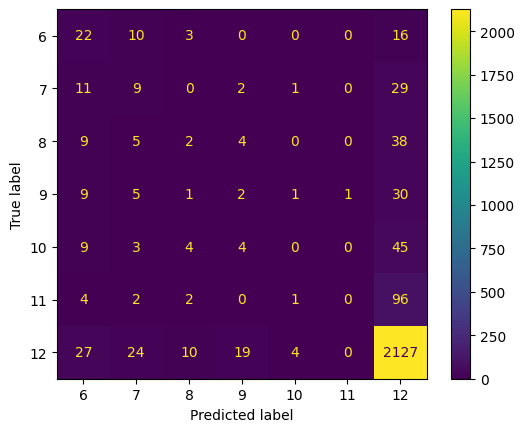

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
# Visualizamos la matriz de confusión
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test);

## Árbol de decisión

In [ ]:
from sklearn.model_selection import train_test_split
# Procedemos igual al caso del clasificador lineal
X = df.drop(columns=['TENURE'])
y = df['TENURE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify = y)
print('Train:', X_train.shape, y_train.shape)
print('Test:',  X_test.shape, y_test.shape)

Train: (6265, 16) (6265,)
Test: (2685, 16) (2685,)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

# Hacemos poda con ccp_alpha
dist = {'ccp_alpha':loguniform(1e-3, 1e3)}
grid_search = RandomizedSearchCV(estimator = DecisionTreeClassifier(), param_distributions = dist, scoring = 'f1_weighted')
grid_search.fit(X_train, y_train)

test_score = f1_score(y_test, grid_search.best_estimator_.predict(X_test), average='weighted')

print(f'Best validation score: {grid_search.best_score_:.3f} with {grid_search.best_params_}')
print(f'Test score: {test_score:.3f}')

Best validation score: 0.879 with {'ccp_alpha': 0.0012899866103460334}
Test score: 0.860


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           6       0.71      0.36      0.48        61
           7       0.56      0.39      0.46        57
           8       0.58      0.25      0.35        59
           9       0.89      0.31      0.46        52
          10       1.00      0.18      0.31        71
          11       0.59      0.33      0.42       110
          12       0.90      0.99      0.94      2275

    accuracy                           0.88      2685
   macro avg       0.75      0.40      0.49      2685
weighted avg       0.87      0.88      0.86      2685



 En este caso se observa que la precisión de la clasificación de la predicción de las variable TENURE se encuentra que se carga mucho peso en 12 meses, teniendo 2275 entradas, mientras que el resto mantienen su promedio de alrededor de 58 datos. Esto hace que tenga buena precisión en 12 meses, pero no el resto de meses. Adicionalmente, tiene un 100% de precisión en 11 y 7 meses, algo raro de ver en modelos predictorios.

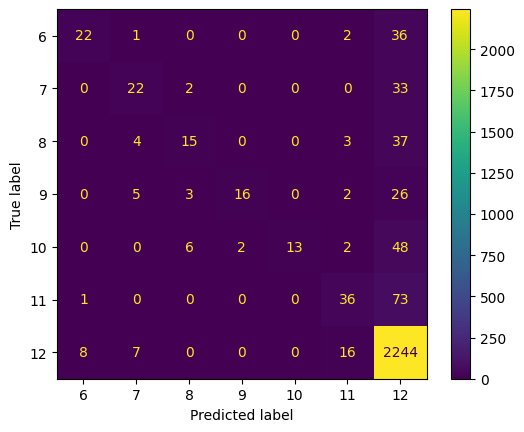

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test);

# Modelos bagging

La primera pregunta que surge es ¿que sentido tiene entrenar muchos árboles con los mismos datos?. En realidad, entrenar muchos estimadores del mismo tipo con el mismo conjunto de datos, conducirá a tener modelos muy similares, y el problema del sobreajuste no se solucionará. En realidad, lo ideal sería tener *un conjunto de datos diferente* para entrenar cada árbol.

¿Cómo conseguimos tener muchos conjuntos de datos diferentes? Usando técnicas de *remuestreo*.

La técnica de remuestreo más utilizada es el *bootstrap*, que consiste en hacer un nuevo dataset del mismo tamaño que conjunto de datos original, eligiendo al azar observaciones de este *una por una*, reemplazando las observaciones que van siendo elegidas. Esto significa que algunas observaciones pueden ser elegidas más de una vez, y algunos pueden no ser elegidas en absoluto. La gráfica siguiente lo ilustra:

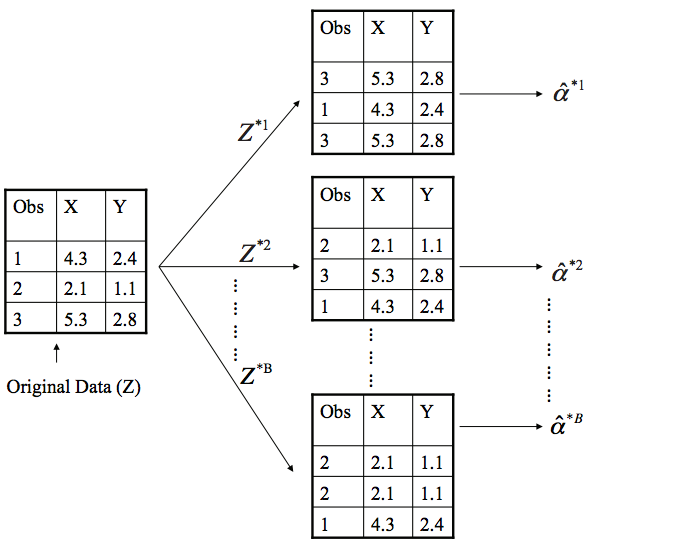

De este manera, podemos generar tantos conjuntos de datos como estimadores por entrenar tengamos. De esta manera, podemos entrenar cada estimador *de manera independiente*, y en paralelo si tenemos varios procesadores.

La siguiente pregunta que surge es ¿cómo se hace una predicción única si todos los estimadores pueden hacer predicciones diferentes?

En modelos de regresión la predicción es el valor promedio de las predicciones de los estimadores, y en clasificación, la predicción es la clase que más frecuentemente ha sido predicha por los estimadores.

Un modelo que funciona así se llama modelo de *Bagging*, y vamos a ver como se codifica.

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

# Instanciamos el modelo de ensamble con los árboles como clasificadores. Tendremos 100 árboles
bag_model = BaggingClassifier(estimator = DecisionTreeClassifier(), n_estimators = 100, random_state = 77)
# Entrenamos el modelo
bag_model.fit(X_train, y_train)
train_score = f1_score(y_train, bag_model.predict(X_train), average = 'weighted')
test_score = f1_score(y_test, bag_model.predict(X_test), average = 'weighted')
print(f'Train score: {train_score:.2f}')
print(f'Test score: {test_score:.2f}')

Train score: 1.00
Test score: 0.92


Este modelo está sobreajustado, así que hay que regularizarlo.

En este caso, se pueden regularizar los árboles limitando la profundidad, y se puede sintonizar el número de estimadores a usar.


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from scipy.stats import loguniform

bag_model = BaggingClassifier(estimator = DecisionTreeClassifier(ccp_alpha = 0.01))
dist = {'n_estimators':range(1, 201)}
grid_search = RandomizedSearchCV(estimator = bag_model, param_distributions = dist, cv = 5, scoring = 'f1_weighted')
grid_search.fit(X_train, y_train)

print(f'Best score: {grid_search.best_score_:.2f} with {grid_search.best_params_}')
print(f'Test score: {grid_search.best_estimator_.score(X_test, y_test):.2f}')

Best score: 0.78 with {'n_estimators': 9}
Test score: 0.85


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           6       0.00      0.00      0.00        61
           7       0.00      0.00      0.00        57
           8       0.00      0.00      0.00        59
           9       0.00      0.00      0.00        52
          10       0.00      0.00      0.00        71
          11       0.00      0.00      0.00       110
          12       0.85      1.00      0.92      2275

    accuracy                           0.85      2685
   macro avg       0.12      0.14      0.13      2685
weighted avg       0.72      0.85      0.78      2685



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


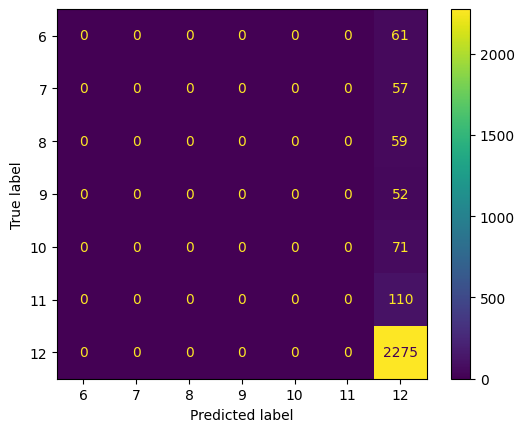

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test);

En este caso el modelo tiene un peor desempeño, ya que solo es capaz de clasificar con precisión el TENURE de 12 meses

# Random Forest

Hacer bootstrapping soluciona el problema de tener muchos datasets. Sin embargo, los datasets generados, al provenir de un único dataset, tienen similaridades entre sí, es decir que no son independientes, y esta condición es deseable para minimizar el *sesgo* que puedan tener los árboles.

Una posible solución, al menos parcialmente, es entrenar cada estimador con *características diferentes*. Esto es lo que hacen los modelos de bosques alaetorios - *Random Forest*.

Un *bosque aleatorio* es un modelo de ensamble formado por muchos árboles de decisión, donde cada uno de ellos es entrenado con un conjunto de datos diferentes generado por la técnica de *bootstrapping*; adicionalmente, para lograr una mayor diversidad de los estimadores, en cada nodo del árbol se selecciona aleatoriamente un subconjunto de características, de las cuales se escogerá la siguiente a usar para particionar el árbol.

Para regularizar un bosque aleatorio y evitar que se sobreajuste existen varios hiperparámetros que se pueden sintonizar; entre estos están:
1. n_estimators: Este hiperparámetro controla la cantidad de árboles de decisión dentro del bosque. Aunque se podría pensar que usar muchos árboles para ajustar un modelo ayudan a obtener un resultado más generalizable, esto no siempre es así. Aunque no causan ningún sobreajuste, aumentan la complejidad temporal del modelo.
2. max_depth: Este hiperparámetro rige la profundidad máxima hasta la que pueden crecer los árboles dentro del bosque. A medida que aumentamos la profundidad del árbol, la precisión del modelo aumenta hasta cierto límite, pero luego comenzará a disminuir gradualmente debido al sobreajuste en el modelo.
3. min_samples_split: Este hiperparámetro especifica la cantidad mínima de muestras que debe tener un nodo interno para dividirse en más nodos. Si tenemos un valor muy bajo de min_samples_splits, entonces, en este caso, el árbol continuará creciendo y comenzará a sobreajustarse.
4. max_features: Este hiperparámetro determina la cantidad de características que se deben considerar al buscar la mejor división. Se puede establecer como un número entero, flotante, string o None. Si es un entero, entonces considera ese número de características en cada división. Si es flotante, entonces muestra un porcentaje y las características $int(max_features * n_features)$ son consideradas en cada división. Si es "sqrt", entonces en cada división son consideradas únicamente la raíz cuadrada del total de características. Si es "log2", entonces solo las $log2(n_features)$ del total de características son consideradas en cada división. Si None, entonces todas las características son consideradas en cada división.
4. min_samples_leaf: Este hiperparámetro especifica el número mínimo de muestras que se deben tener en un nodo hoja. Un punto de división en cualquier profundidad solo se considerará si deja al menos min_samples_leaf muestras de entrenamiento en cada una de las ramas izquierda y derecha.
5. ccp_alpha: es un parámetro que se utiliza en un algoritmo de podado en los árboles de decisión, basado en la relación entre costo y complejidad. Un valor más alto de ccp_alpha resultará en árboles más pequeños y un modelo más simple, mientras que un valor más bajo permitirá que los árboles crezcan más y resultará en un modelo más complejo.

Vamos a entrenar un bosque aleatorio sintonizando algunos de estos hiperparámetros:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from scipy.stats import loguniform

rf_model = RandomForestClassifier(random_state=77)
dist = {'n_estimators':range(1, 201), 'ccp_alpha':loguniform(1e-4, 1e2)}
grid_search = RandomizedSearchCV(estimator=rf_model, param_distributions=dist, cv=5, random_state=77, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

test_score = f1_score(y_test, grid_search.predict(X_test), average='weighted')
print(f'Best score: {grid_search.best_score_:.2f} with {grid_search.best_params_}')
print(f'Test score: {grid_search.best_estimator_.score(X_test, y_test):.2f}')

Best score: 0.84 with {'ccp_alpha': 0.0006853105358132067, 'n_estimators': 186}
Test score: 0.88


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           6       1.00      0.38      0.55        61
           7       1.00      0.21      0.35        57
           8       0.81      0.29      0.42        59
           9       0.90      0.17      0.29        52
          10       0.80      0.11      0.20        71
          11       1.00      0.09      0.17       110
          12       0.88      1.00      0.93      2275

    accuracy                           0.88      2685
   macro avg       0.91      0.32      0.42      2685
weighted avg       0.88      0.88      0.84      2685



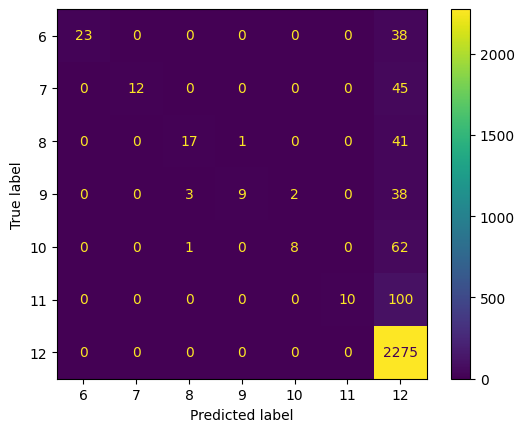

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test);

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from scipy.stats import loguniform

rf_model = RandomForestClassifier(random_state=77)
dist = {'n_estimators':range(1, 201), 'max_depth':range(2,10), 'min_samples_split':range(2,5)}
grid_search = RandomizedSearchCV(estimator=rf_model, param_distributions=dist, cv=5, random_state=77, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

test_score = f1_score(y_test, grid_search.predict(X_test), average='weighted')
print(f'Best score: {grid_search.best_score_:.2f} with {grid_search.best_params_}')
print(f'Test score: {grid_search.best_estimator_.score(X_test, y_test):.2f}')

Best score: 0.82 with {'n_estimators': 69, 'min_samples_split': 2, 'max_depth': 8}
Test score: 0.87


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           6       0.94      0.28      0.43        61
           7       1.00      0.19      0.32        57
           8       0.82      0.24      0.37        59
           9       0.88      0.13      0.23        52
          10       0.73      0.11      0.20        71
          11       1.00      0.06      0.12       110
          12       0.87      1.00      0.93      2275

    accuracy                           0.87      2685
   macro avg       0.89      0.29      0.37      2685
weighted avg       0.88      0.87      0.83      2685



Al observar el modelo, la precisin mejoro muchisimo respecto al modelo anterior, en este caso por lo menos es capaz de predecir el resto de cantidad de meses.

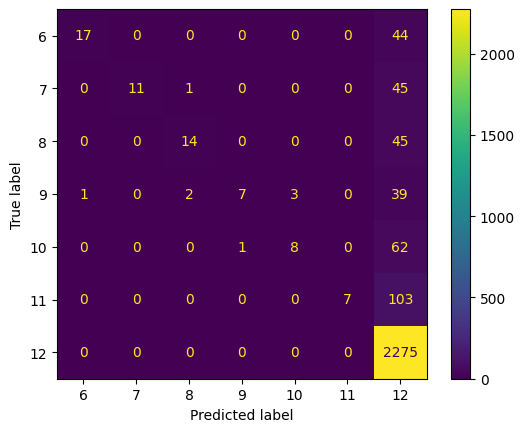

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test);

Una desventaja de estos modelos es que no son tan fáciles de interpretar como los modelos lineales, en los cuales podemos saber con certeza cuando pesa cada característica en la predicción, o los árboles de decisión, en los que se puede construir un grafo que representa las decisiones que se tomaron para hacer una predicción.

Con los modelos de ensamble no tenemos nada de eso, pero en la implementación de Scikit Learn tienen el atributo *features_importances_*, que, como su nombre lo indica, entrega la importancia de cada característica computada mediante el algoritmo de Gini.



In [ ]:
rf_features = pd.DataFrame({'Feature': X.columns, 'Importance': grid_search.best_estimator_.feature_importances_})
rf_features.sort_values('Importance', ascending=False)

,Feature,Importance
1,BALANCE_FREQUENCY,0.156623
9,CASH_ADVANCE_FREQUENCY,0.153111
14,MINIMUM_PAYMENTS,0.100446
8,PURCHASES_INSTALLMENTS_FREQUENCY,0.089316
13,PAYMENTS,0.075530
6,PURCHASES_FREQUENCY,0.069230
0,BALANCE,0.052353
12,CREDIT_LIMIT,0.050288
11,PURCHASES_TRX,0.049889
7,ONEOFF_PURCHASES_FREQUENCY,0.049261


Por el algoritmo de Gini se puede observar que las variable scon mayor importancia son

BALANCE_FREQUENCY 15,66%

CASH_ADVANCE_FREQUENCY	15,31%

MINIMUM_PAYMENTS 10,04%

PURCHASES_INSTALLMENTS_FREQUENCY	8,93%

PAYMENTS	7,55%

Estas son las que mas resaltan en el modelo.

# Gradient Boosting

Los modelos de gradient boosting se diferencian de otros métodos de ensamble en que **aprenden de forma aditiva**. Esto significa que cada nuevo árbol de decisión se entrena utilizando los errores de los árboles anteriores, lo que permite al modelo mejorar iterativamente su rendimiento.

**¿Cómo funciona el proceso?**

1. **Árbol inicial:** Se comienza con un **árbol de decisión inicial**, que puede ser un árbol simple o generado aleatoriamente. Este árbol predice los valores para el conjunto de datos.

2. **Errores residuales:** Se calculan los **errores residuales**, que son la diferencia entre las predicciones del árbol inicial y los valores reales del conjunto de datos.

3. **Nuevo árbol:** Se entrena un **nuevo árbol de decisión** utilizando los errores residuales del paso anterior. El objetivo de este nuevo árbol es **corregir los errores del árbol inicial**.

4. **Combinación:** Se **combinan las predicciones del nuevo árbol** con las del árbol inicial. La forma de combinarlas depende del algoritmo específico de gradient boosting utilizado, pero generalmente se utiliza una **ponderación** que refleja la importancia de cada árbol.

5. **Repetición:** Se repiten los pasos 2 a 4, **entrenando un nuevo árbol de decisión** y combinándolo con los anteriores, hasta que se alcanza el número máximo de árboles o se cumple un criterio de parada.

**¿Qué ventajas tienen los modelos de gradient boosting?**

* **Precisión:** Los modelos de gradient boosting pueden ser **muy precisos**, especialmente cuando se utilizan con conjuntos de datos grandes y complejos.
* **Robustez:** Son **robustos a los outliers** y al **ruido** en los datos.
* **Versatilidad:** Se pueden utilizar para una **amplia variedad de tareas de aprendizaje automático**, como regresión, clasificación y problemas de ranking.

**¿Qué desventajas tienen los modelos de gradient boosting?**

* **Sobreajuste:** Si no se tiene cuidado, los modelos de gradient boosting pueden **sobreajustarse** a los datos de entrenamiento, lo que significa que no se generalizan bien a nuevos datos.
* **Computación:** Entrenar un modelo de gradient boosting puede ser **computacionalmente costoso**, especialmente cuando se utilizan conjuntos de datos grandes o un gran número de árboles.



En un modelo de **gradient boosting** se pueden ajustar varios **hiperparámetros** para optimizar su rendimiento. Además de los ya vistos en los árboles de decisión y los bosques aleatorios, estos hiperparámetros adicionales se pueden sintonizar:

* **learning_rate:** Controla el tamaño del paso que se da en la dirección del gradiente durante el entrenamiento. Un valor grande puede conducir a un entrenamiento más rápido, pero también puede aumentar el riesgo de sobreajuste.
* **Función de pérdida (loss):** Define la forma en que se mide el error del modelo. La función de pérdida más común para el gradient boosting es la **función de pérdida cuadrática** para problemas de regresión y la **función de pérdida logarítmica** para problemas de clasificación.
* **Criterio de parada (n_iter_no_change, validation_fraction y tol):** Determina cuándo se detiene el entrenamiento del modelo. Se pueden utilizar diferentes criterios como un cierto nivel de precisión o una mejora mínima en la precisión.

Vamos a entrenar un modelo de *gradient boosting* sintonizando algunos de estos hiperparámetros:

In [ ]:
from sklearn.model_selection import train_test_split

df_dropna = df.dropna()
X = df_dropna.drop(columns=['TENURE'])
y = df_dropna['TENURE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
print('Train:', X_train.shape, y_train.shape)
print('Test:',  X_test.shape, y_test.shape)

Train: (6045, 16) (6045,)
Test: (2591, 16) (2591,)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from scipy.stats import uniform

gb_model = GradientBoostingClassifier(n_iter_no_change=5)
dist = {'n_estimators':range(1, 201), 'max_depth':range(1,10), 'learning_rate':uniform(0,1), 'min_samples_split':range(2,5)}
grid_search = RandomizedSearchCV(estimator=gb_model, param_distributions=dist, cv=5, random_state=77, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

test_score = f1_score(y_test, grid_search.predict(X_test), average='weighted')
print(f'Best score: {grid_search.best_score_:.3f} with {grid_search.best_params_}')
print(f'Test score: {test_score:.3f}')

Best score: 0.910 with {'learning_rate': 0.33574626121053397, 'max_depth': 4, 'min_samples_split': 4, 'n_estimators': 192}
Test score: 0.909


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           6       0.52      0.44      0.48        55
           7       0.85      0.66      0.74        53
           8       0.79      0.42      0.55        55
           9       0.73      0.71      0.72        49
          10       0.84      0.62      0.71        68
          11       0.81      0.49      0.61       107
          12       0.94      0.98      0.96      2204

    accuracy                           0.92      2591
   macro avg       0.78      0.62      0.68      2591
weighted avg       0.91      0.92      0.91      2591



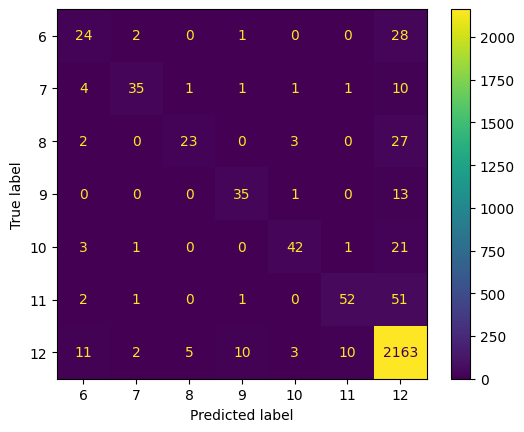

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test);

Estos modelos también entregan la importancia relativa de cada característica en el modelo:

In [ ]:
gb_features = pd.DataFrame({'Feature': X.columns, 'Importance': grid_search.best_estimator_.feature_importances_})
gb_features.sort_values('Importance', ascending=False)

,Feature,Importance
1,BALANCE_FREQUENCY,0.294623
9,CASH_ADVANCE_FREQUENCY,0.250054
8,PURCHASES_INSTALLMENTS_FREQUENCY,0.107405
7,ONEOFF_PURCHASES_FREQUENCY,0.067588
13,PAYMENTS,0.058457
14,MINIMUM_PAYMENTS,0.056101
6,PURCHASES_FREQUENCY,0.035735
12,CREDIT_LIMIT,0.030224
0,BALANCE,0.027937
5,CASH_ADVANCE,0.015823


En este caso, para la base de datos que estamos usando, el Gradient Boosting dio mejores resultados respecto a la clasificación. Además cambio parte de las caracteristicas de mayor importancia, subiendo hasta 6,75% de importancia el ONEOFF_PURCHASES_FREQUENCY.

# Modelos de regresión

In [ ]:
from sklearn.model_selection import train_test_split

df_dropna = df.dropna()
X = df_dropna.drop(columns=['CREDIT_LIMIT'])
y = df_dropna['CREDIT_LIMIT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print('Train:', X_train.shape, y_train.shape)
print('Test:',  X_test.shape, y_test.shape)

Train: (6045, 16) (6045,)
Test: (2591, 16) (2591,)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.linear_model import Ridge

num_vars = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'PAYMENTS', 'MINIMUM_PAYMENTS'] # Se definen las variables numéricas
ohe = OneHotEncoder(sparse_output=False, drop='first')
poly = PolynomialFeatures(degree=2)
ss = StandardScaler()
pre_num = Pipeline(steps=[('poly', poly), ('ss', ss)])

preprocessor = ColumnTransformer(transformers = [('pre_num', pre_num, num_vars)], remainder='drop')

pipe = Pipeline([('preprocessor', preprocessor), ('model', Ridge())])
dist = {'model__alpha':loguniform(1e-4, 1e2)}

grid_search = RandomizedSearchCV(estimator=pipe, cv=5, param_distributions=dist, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

test_score = root_mean_squared_error(y_test, grid_search.predict(X_test))
print(f'Best score: {-grid_search.best_score_:.2f} with {grid_search.best_params_}')
print(f'Test score: {test_score:.2f}')

Best score: 2736.70 with {'model__alpha': 8.944065594403027}
Test score: 2770.80


In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['CREDIT_LIMIT'])
y = df['CREDIT_LIMIT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print('Train:', X_train.shape, y_train.shape)
print('Test:',  X_test.shape, y_test.shape)

Train: (6265, 16) (6265,)
Test: (2685, 16) (2685,)


In [ ]:
#elimina de CREDIT_LIMIT la entrada "nan"
df = df.dropna(subset=['CREDIT_LIMIT'])

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error

dist = {'ccp_alpha':loguniform(1e-3, 1e2)}
grid_search = RandomizedSearchCV(estimator=DecisionTreeRegressor(), cv=5, param_distributions=dist, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

test_score = root_mean_squared_error(y_test, grid_search.predict(X_test))
print(f'Best score: {-grid_search.best_score_:.2f} with {grid_search.best_params_}')
print(f'Test score: {test_score:.2f}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py", line 581, in r

ValueError: Input y contains NaN.

## Regresor bagging

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

bag_model = BaggingRegressor(estimator=DecisionTreeRegressor())

dist = {'n_estimators':range(1, 201)}
grid_search = RandomizedSearchCV(estimator=bag_model, param_distributions=dist, cv=5, random_state=77, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)
test_score = root_mean_squared_error(y_test, grid_search.predict(X_test))
print(f'Best score: {-grid_search.best_score_:.2f} with {grid_search.best_params_}')
print(f'Test score: {test_score:.2f}')

Best score: 2.80 with {'n_estimators': 75}
Test score: 2.80


## Random Forest


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from scipy.stats import loguniform

rf_model = RandomForestRegressor()
dist = {'n_estimators':range(1, 201), 'max_depth':range(2,10), 'min_samples_split':range(2,5)}
grid_search = RandomizedSearchCV(estimator=rf_model, param_distributions=dist, cv=5, random_state=77, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)
test_score = root_mean_squared_error(y_test, grid_search.predict(X_test))
print(f'Best score: {-grid_search.best_score_:.2f} with {grid_search.best_params_}')
print(f'Test score: {test_score:.2f}')

Best score: 2.83 with {'n_estimators': 114, 'min_samples_split': 4, 'max_depth': 7}
Test score: 2.75


In [ ]:
rf_features = pd.DataFrame({'Feature': X.columns, 'Importance': grid_search.best_estimator_.feature_importances_})
rf_features.sort_values('Importance', ascending=False)

,Feature,Importance
3,weight,0.387643
0,cylinders,0.200606
1,displacement,0.140140
5,model year,0.135082
2,horsepower,0.107157
4,acceleration,0.024001
6,origin,0.005371


## Boosting Regressor

In [ ]:
from sklearn.model_selection import train_test_split

df_dropna = df.dropna()
X = df_dropna.drop(columns=['mpg'])
y = df_dropna['mpg']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print('Train:', X_train.shape, y_train.shape)
print('Test:',  X_test.shape, y_test.shape)

Train: (274, 7) (274,)
Test: (118, 7) (118,)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error
from scipy.stats import loguniform, uniform

gb_model = GradientBoostingRegressor(n_iter_no_change=5)
dist = {'n_estimators':range(1, 201), 'max_depth':range(2,10), 'min_samples_split':range(2,5), 'learning_rate':uniform(0,1), 'loss':['squared_error', 'huber', 'quantile', 'absolute_error']}
grid_search = RandomizedSearchCV(estimator=gb_model, param_distributions=dist, cv=5, random_state=77, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)
test_score = root_mean_squared_error(y_test, grid_search.predict(X_test))
print(f'Best score: {-grid_search.best_score_:.2f} with {grid_search.best_params_}')
print(f'Test score: {test_score:.2f}')

Best score: 3.01 with {'learning_rate': 0.5884811425466829, 'loss': 'huber', 'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 82}
Test score: 3.66


In [ ]:
gb_features = pd.DataFrame({'Feature': X.columns, 'Importance': grid_search.best_estimator_.feature_importances_})
gb_features.sort_values('Importance', ascending=False)

,Feature,Importance
0,cylinders,0.620313
3,weight,0.150245
5,model year,0.130198
2,horsepower,0.064868
1,displacement,0.013696
4,acceleration,0.012097
6,origin,0.008583
